In [5]:
import sys
sys.path.append("..")

In [6]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

In [7]:
x1 = torch.rand(10, 1) * 10.0 - 15.2
x2 = torch.rand(5, 1) * 10.4 + 5.2
x = torch.cat([x1, x2])
sigma = 0.05
noise = torch.normal(mean=torch.full_like(x, 0.), std=sigma)
y = 0.02*x + x.mul(0.5).add(-0.2).sin().mul(0.2) + noise

x_test = torch.linspace(-20, 20, 401).unsqueeze(-1)

y_test = 0.02*x_test + x_test.mul(0.5).add(-0.2).sin().mul(0.2)

In [8]:
x.shape, y.shape

(torch.Size([15, 1]), torch.Size([15, 1]))

In [9]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

In [10]:
x1, y1 = next(iter(loader))

(-1.5, 1.5)

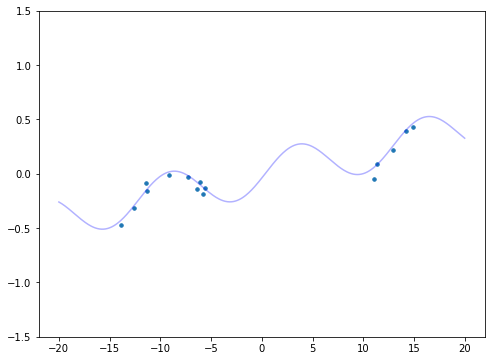

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.ylim(-1.5, 1.5)

In [12]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(20000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-1.5, 1.5)

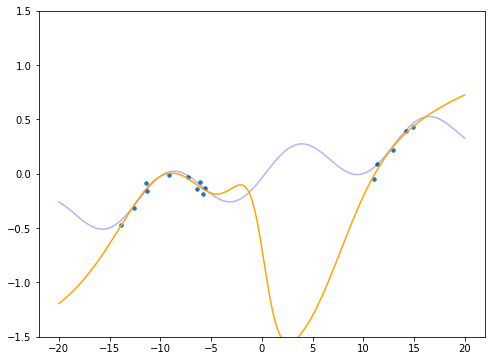

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, net(x_test).detach(), color="orange")
plt.ylim(-1.5, 1.5)


In [14]:
net = nn.Sequential(nn.Linear(1, 32), nn.Tanh(), nn.Linear(32, 1))

In [15]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [16]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.01)

In [17]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.1)

In [18]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [19]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.flipout():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 148615.046875
epoch: 1000 | elbo: 21649.513671875
epoch: 2000 | elbo: 10414.75390625
epoch: 3000 | elbo: 4740.04638671875
epoch: 4000 | elbo: 4415.59228515625
epoch: 5000 | elbo: 3032.54638671875
epoch: 6000 | elbo: 3083.34765625
epoch: 7000 | elbo: 2635.5791015625
epoch: 8000 | elbo: 1346.045166015625


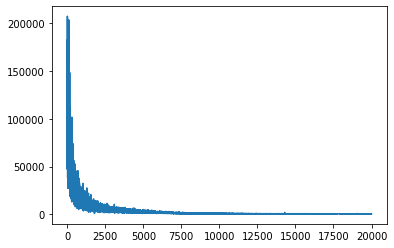

In [ ]:
plt.plot(elbos)

In [ ]:
#with tyxe.poutine.local_reparameterization():
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()


(-1.5, 1.5)

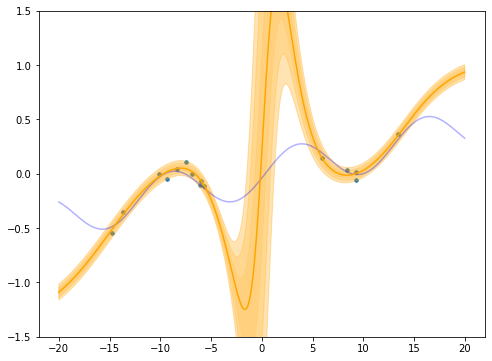

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

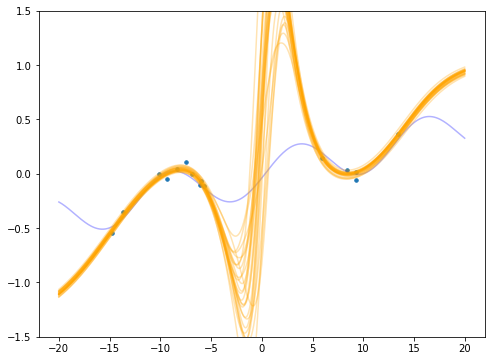

In [ ]:

sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="orange", alpha=0.3)
plt.ylim(-1.5, 1.5)

In [20]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [21]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 13107.5556640625
epoch: 1000 | elbo: 560.4853515625
epoch: 2000 | elbo: 475.3692321777344
epoch: 3000 | elbo: 411.5968933105469
epoch: 4000 | elbo: 401.909423828125
epoch: 5000 | elbo: 312.59478759765625
epoch: 6000 | elbo: 255.52639770507812
epoch: 7000 | elbo: 212.34901428222656
epoch: 8000 | elbo: 157.47190856933594
epoch: 9000 | elbo: 124.6539306640625
epoch: 10000 | elbo: 97.60101318359375
epoch: 11000 | elbo: 67.49118041992188
epoch: 12000 | elbo: 53.03279495239258
epoch: 13000 | elbo: 50.75941467285156
epoch: 14000 | elbo: 47.11913299560547
epoch: 15000 | elbo: 48.12781524658203
epoch: 16000 | elbo: 43.87224197387695
epoch: 17000 | elbo: 45.516136169433594
epoch: 18000 | elbo: 47.74923324584961
epoch: 19000 | elbo: 43.51197052001953


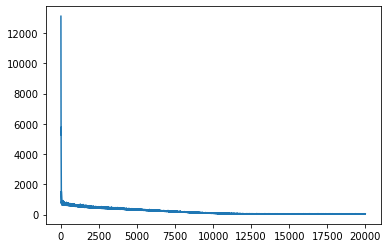

In [22]:
plt.plot(elbos)

In [23]:
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()

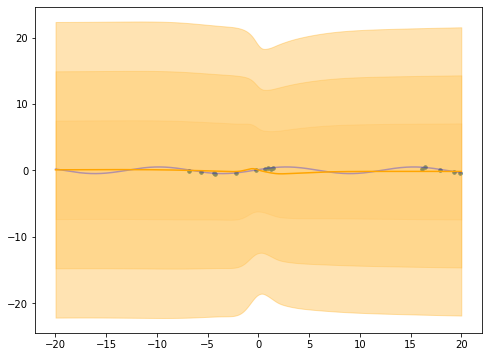

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")